# This notebook is on building LSTM models(Univariate, Multivariate and Encoder-Decoder)

## Load Data for EDA

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load raw features
PROJECT_PATH = r"C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-"

DATA_FEATURING_PATH = os.path.join(PROJECT_PATH, "Data_Featuring")
raw_path = os.path.join(DATA_FEATURING_PATH, "features_raw.parquet")

df_raw = pd.read_parquet(raw_path)

print("Loaded raw dataset for EDA")
print("Shape:", df_raw.shape)
df_raw.head(5)


Loaded raw dataset for EDA
Shape: (1271, 85)


,player_id,season,avg_market_value,max_market_value,min_market_value,player_name,num_transfers,avg_transfer_fee,last_transfer_fee,avg_transfer_premium,...,total_yellow_cards_missing,total_red_cards_missing,matches_played_missing,contract_year_remaining,foot___MISSING__,foot_both,foot_left,foot_right,club_prestige_score,subreddits_count
0,123951,2022,4.500000e+06,5000000.0,4000000.0,aaron mooy,0.0,0.000000,0.0,0.000000e+00,...,1,1,1,3.0,0,0,0,1,14,3
1,50057,2020,2.625000e+07,35000000.0,20000000.0,aaron ramsey,0.0,0.000000,0.0,0.000000e+00,...,0,0,0,5.0,0,0,0,1,7,0
2,50057,2022,3.000000e+06,3000000.0,3000000.0,aaron ramsey,0.0,0.000000,0.0,0.000000e+00,...,1,1,1,3.0,0,0,0,1,7,0
3,243633,2023,3.833333e+05,450000.0,350000.0,aaron tshibola,1.0,200000.000000,200000.0,-1.500000e+05,...,1,1,1,2.0,0,0,0,1,1,1
4,340394,2022,3.333333e+06,4000000.0,3000000.0,abdelhamid sabiri,3.0,333333.333333,1000000.0,-2.333333e+06,...,1,1,1,4.0,0,0,0,1,6,2


## Target Variable (max_market_value)

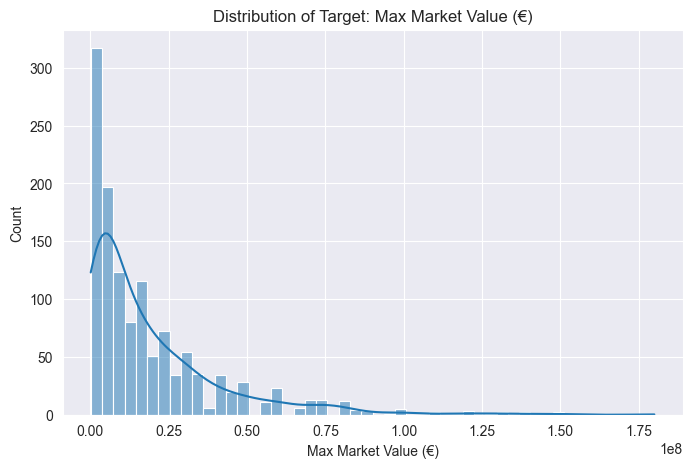

count    1.271000e+03
mean     1.901121e+07
std      2.275452e+07
min      1.000000e+05
25%      3.800000e+06
50%      1.000000e+07
75%      2.500000e+07
max      1.800000e+08
Name: max_market_value, dtype: float64


In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df_raw["max_market_value"], bins=50, kde=True)
plt.title("Distribution of Target: Max Market Value (€)")
plt.xlabel("Max Market Value (€)")
plt.show()

print(df_raw["max_market_value"].describe())


## Correlations with Target

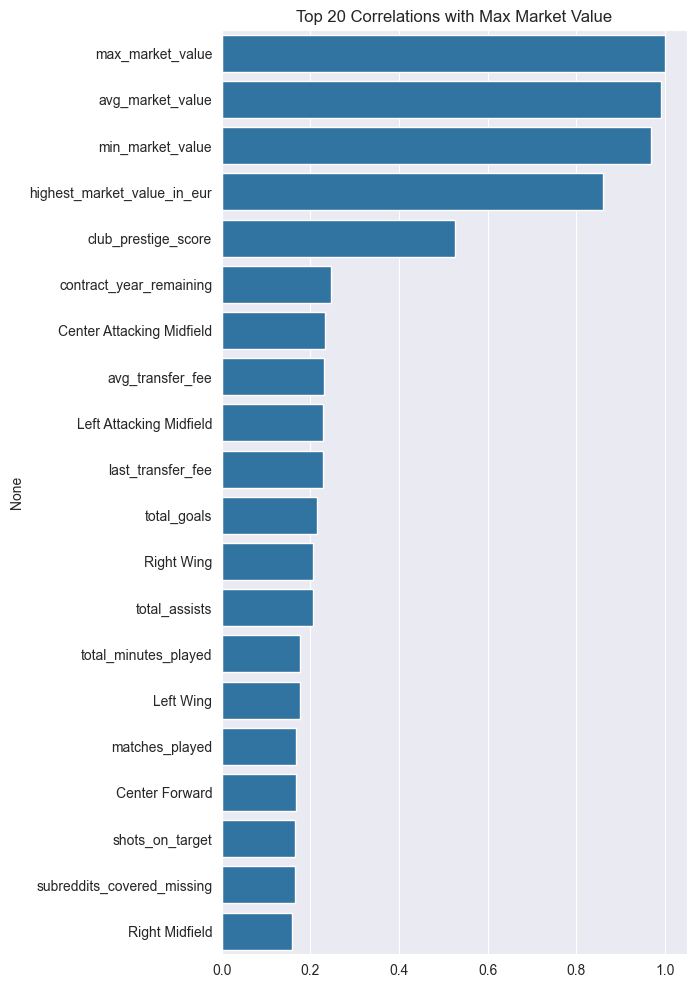

max_market_value               1.000000
avg_market_value               0.992279
min_market_value               0.968425
highest_market_value_in_eur    0.859549
club_prestige_score            0.526088
contract_year_remaining        0.246661
Center Attacking Midfield      0.231999
avg_transfer_fee               0.229511
Left Attacking Midfield        0.228824
last_transfer_fee              0.227758
total_goals                    0.215145
Right Wing                     0.205515
total_assists                  0.204714
total_minutes_played           0.176862
Left Wing                      0.175854
matches_played                 0.167555
Center Forward                 0.166397
shots_on_target                0.166048
subreddits_covered_missing     0.164923
Right Midfield                 0.157188
Name: max_market_value, dtype: float64


In [6]:
corr = df_raw.corr(numeric_only=True)["max_market_value"].sort_values(ascending=False)

plt.figure(figsize=(6,12))
sns.barplot(x=corr.values[:20], y=corr.index[:20])
plt.title("Top 20 Correlations with Max Market Value")
plt.show()

print(corr.head(20))


## Sentiment Features

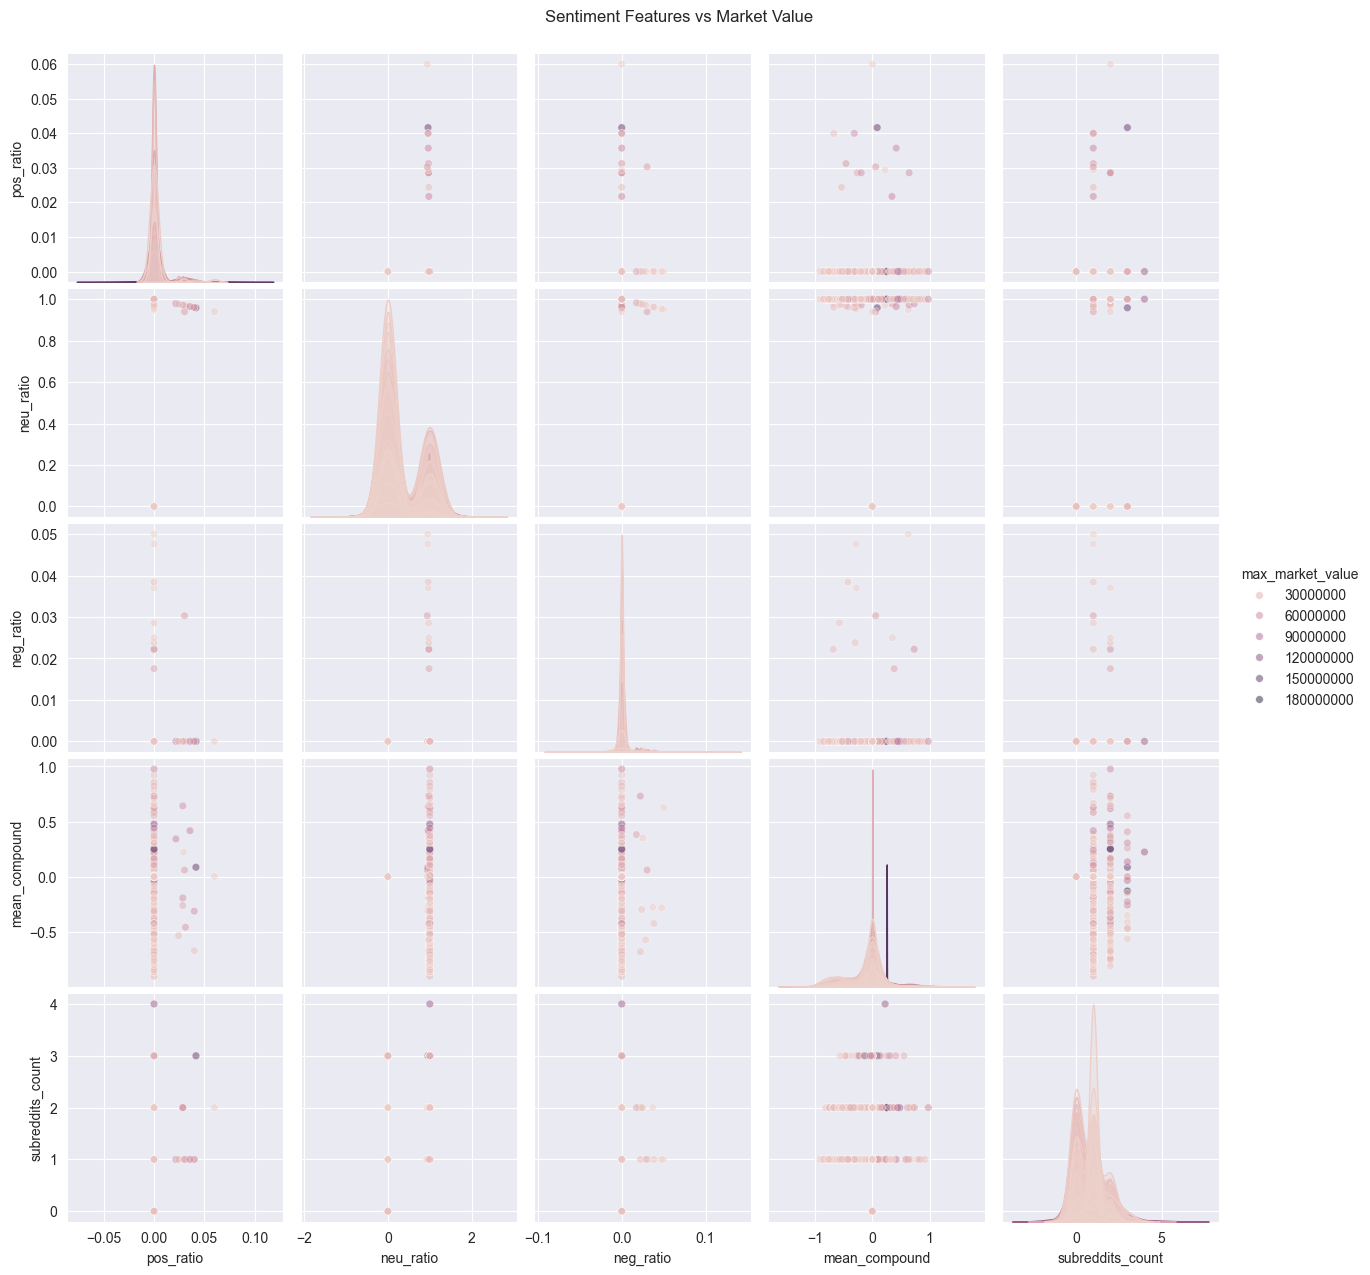

In [7]:
sentiment_cols = ["pos_ratio", "neu_ratio", "neg_ratio", "mean_compound", "subreddits_count"]

sns.pairplot(df_raw, vars=sentiment_cols, hue="max_market_value",
             plot_kws={'alpha':0.5, 's':30}, diag_kind="kde")
plt.suptitle("Sentiment Features vs Market Value", y=1.02)
plt.show()


## Season Trends

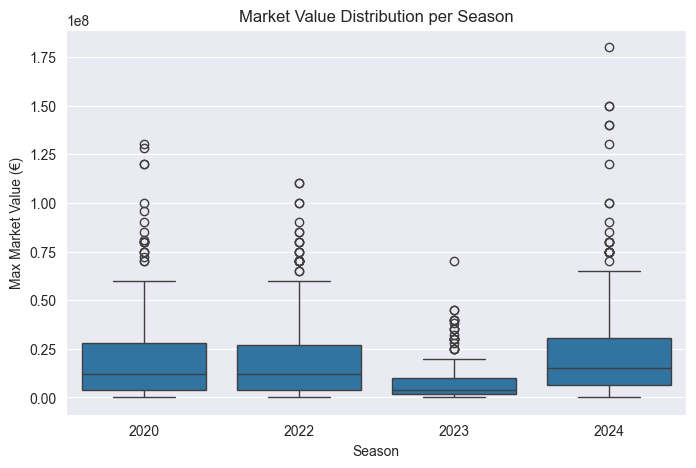

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(x="season", y="max_market_value", data=df_raw)
plt.title("Market Value Distribution per Season")
plt.xlabel("Season")
plt.ylabel("Max Market Value (€)")
plt.show()


## Popularity Proxy

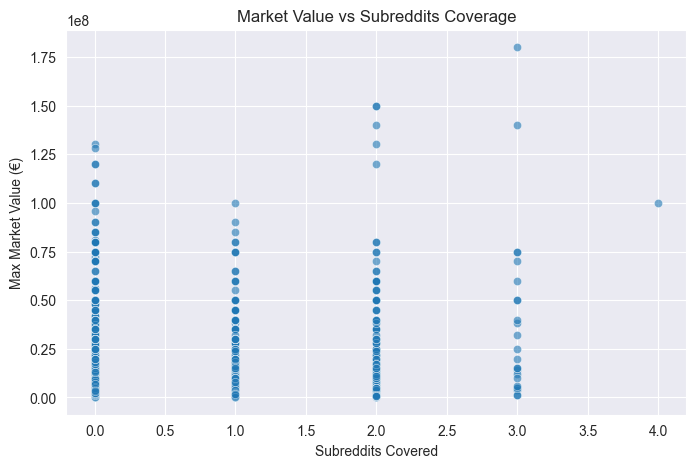

In [9]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="subreddits_count", y="max_market_value", data=df_raw, alpha=0.6)
plt.title("Market Value vs Subreddits Coverage")
plt.xlabel("Subreddits Covered")
plt.ylabel("Max Market Value (€)")
plt.show()


## Applying a log-transform to the target and compare before/after distribution


Reloaded dataset for EDA: (1271, 85)


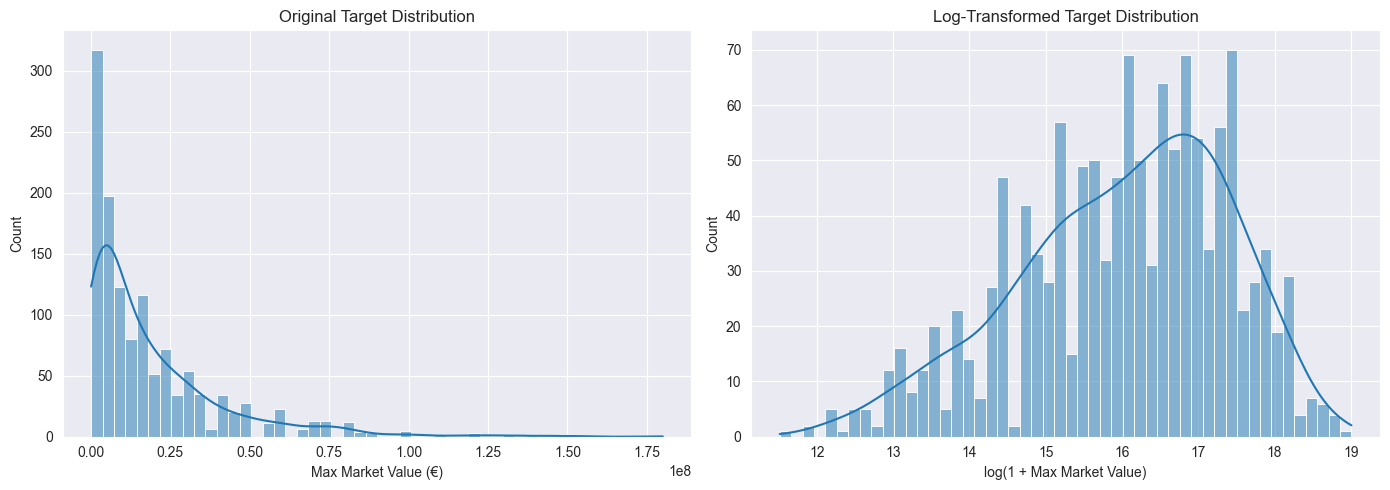

,max_market_value,log_max_market_value
count,1.271000e+03,1271.000000
mean,1.901121e+07,16.013045
std,2.275452e+07,1.391288
min,1.000000e+05,11.512935
25%,3.800000e+06,15.150512
50%,1.000000e+07,16.118096
75%,2.500000e+07,17.034386
max,1.800000e+08,19.008467


In [10]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = os.path.join(DATA_FEATURING_PATH, "features_clean.csv")

# load clean dataset
df_eda = pd.read_csv(csv_path)

print("Reloaded dataset for EDA:", df_eda.shape)

# Add log-transformed target
df_eda["log_max_market_value"] = np.log1p(df_eda["max_market_value"])  # log(1 + x)

# Plot before and after transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_eda["max_market_value"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Original Target Distribution")
axes[0].set_xlabel("Max Market Value (€)")

sns.histplot(df_eda["log_max_market_value"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Log-Transformed Target Distribution")
axes[1].set_xlabel("log(1 + Max Market Value)")

plt.tight_layout()
plt.show()

df_eda[["max_market_value", "log_max_market_value"]].describe()


C:\Users\asing\AppData\Local\Temp\ipykernel_10188\579637842.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corrs.values, y=top_corrs.index, palette="viridis")


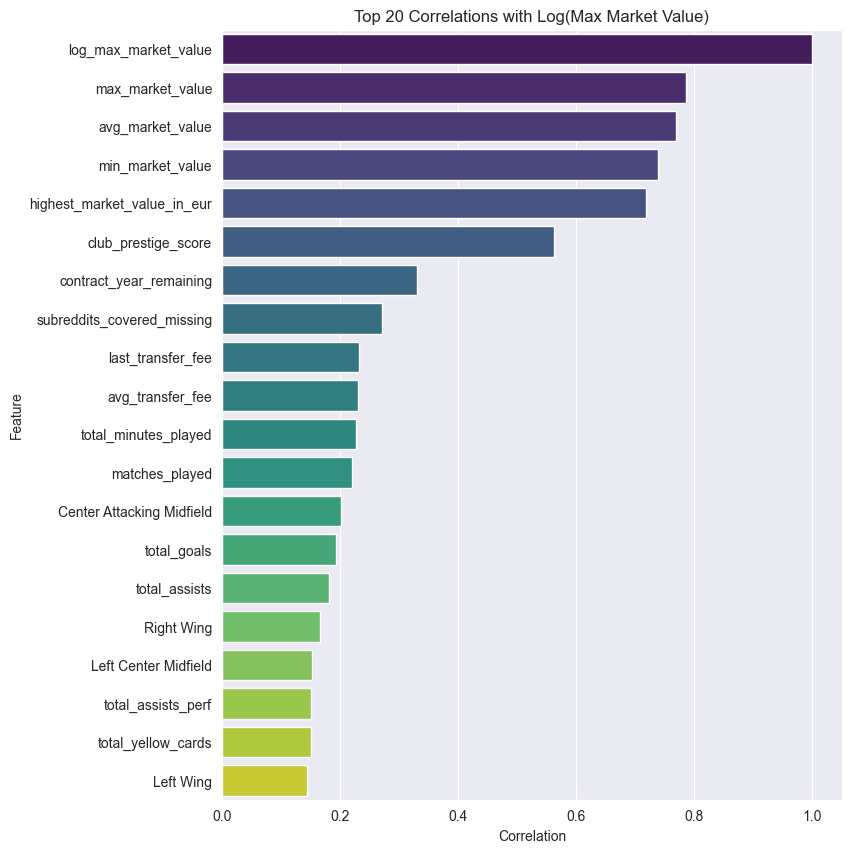

log_max_market_value           1.000000
max_market_value               0.785180
avg_market_value               0.768491
min_market_value               0.738039
highest_market_value_in_eur    0.717972
club_prestige_score            0.562981
contract_year_remaining        0.330958
subreddits_covered_missing     0.270461
last_transfer_fee              0.232320
avg_transfer_fee               0.230092
total_minutes_played           0.227009
matches_played                 0.221137
Center Attacking Midfield      0.201524
total_goals                    0.192637
total_assists                  0.181749
Right Wing                     0.166179
Left Center Midfield           0.152983
total_assists_perf             0.151262
total_yellow_cards             0.151262
Left Wing                      0.143896
Name: log_max_market_value, dtype: float64

In [11]:

# Compute correlations
corrs = df_eda.corr(numeric_only=True)["log_max_market_value"].sort_values(ascending=False)

# Show top 20
top_corrs = corrs.head(20)

plt.figure(figsize=(8, 10))
sns.barplot(x=top_corrs.values, y=top_corrs.index, palette="viridis")
plt.title("Top 20 Correlations with Log(Max Market Value)")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

top_corrs


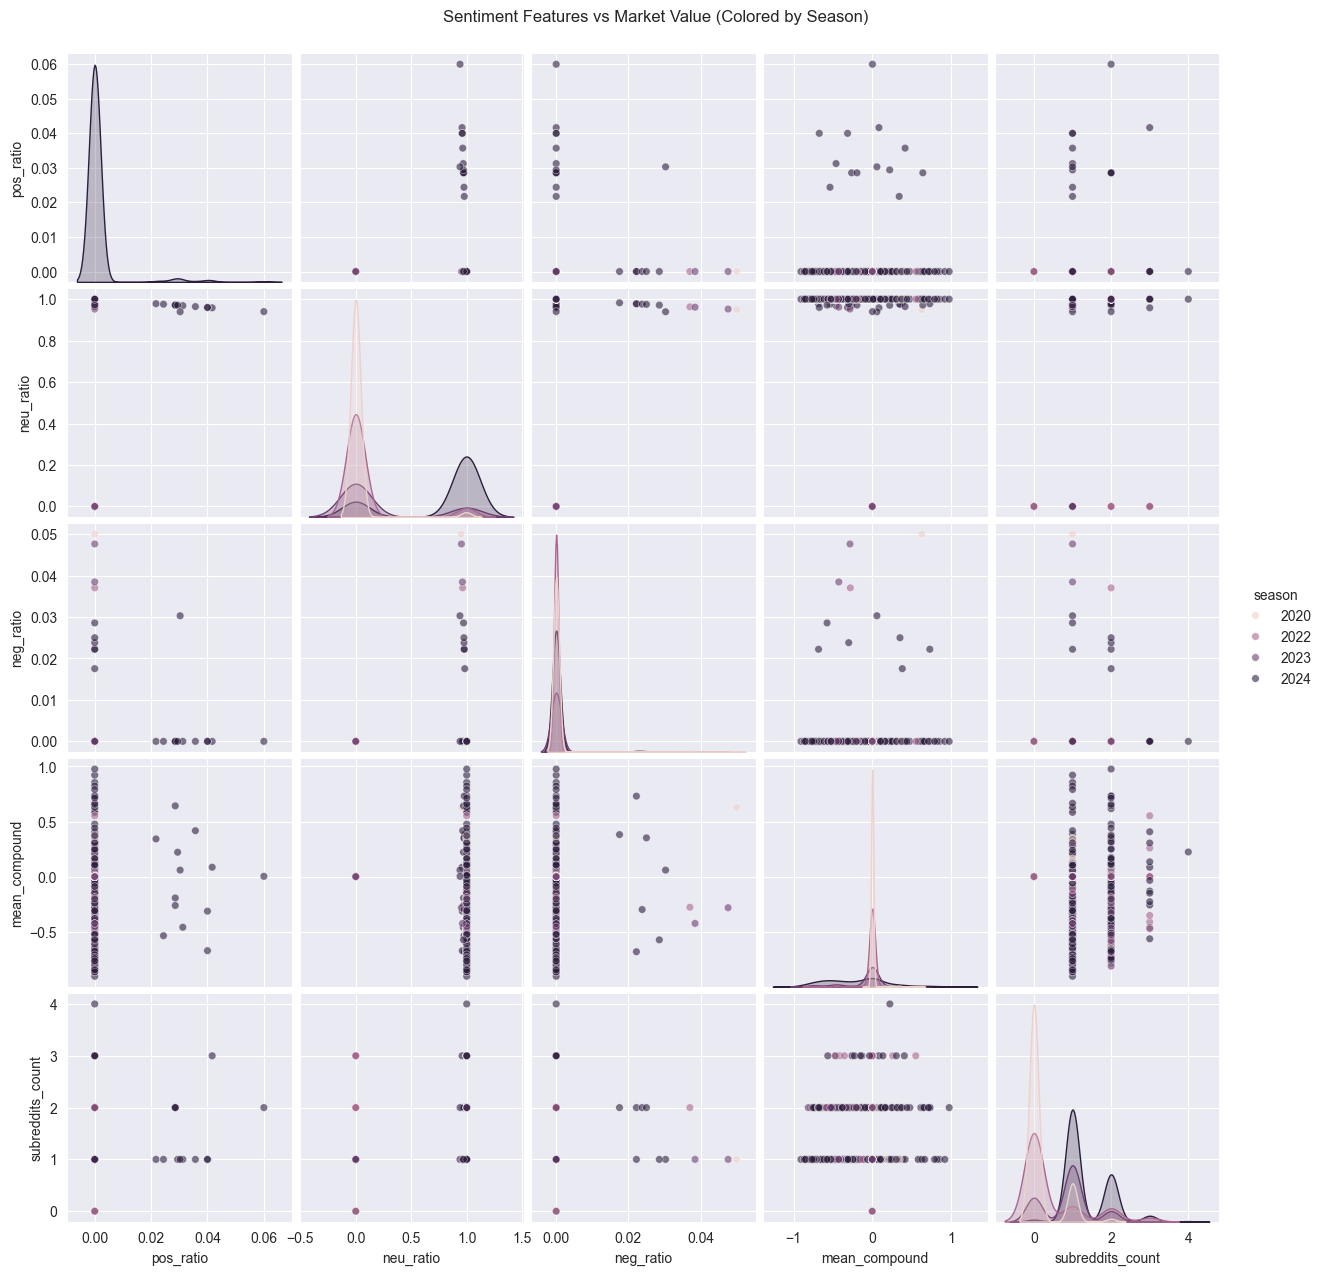

,pos_ratio,neu_ratio,neg_ratio,mean_compound,subreddits_count,log_max_market_value
pos_ratio,1.000000,0.148248,0.058436,0.006838,0.106125,0.072122
neu_ratio,0.148248,1.000000,0.134734,-0.517085,0.617663,0.104836
neg_ratio,0.058436,0.134734,1.000000,0.013972,0.078596,-0.050185
mean_compound,0.006838,-0.517085,0.013972,1.000000,-0.233502,0.044840
subreddits_count,0.106125,0.617663,0.078596,-0.233502,1.000000,-0.115006
log_max_market_value,0.072122,0.104836,-0.050185,0.044840,-0.115006,1.000000


In [12]:

sentiment_cols = ["pos_ratio", "neu_ratio", "neg_ratio", "mean_compound", "subreddits_count"]

sns.pairplot(
    df_eda,
    vars=sentiment_cols,
    hue="season",
    diag_kind="kde",
    plot_kws={"alpha": 0.6, "s": 30}
)
plt.suptitle("Sentiment Features vs Market Value (Colored by Season)", y=1.02)
plt.show()

df_eda[sentiment_cols + ["log_max_market_value"]].corr()


C:\Users\asing\AppData\Local\Temp\ipykernel_10188\2980904647.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="season", y="log_max_market_value", data=df_eda, palette="Set2")


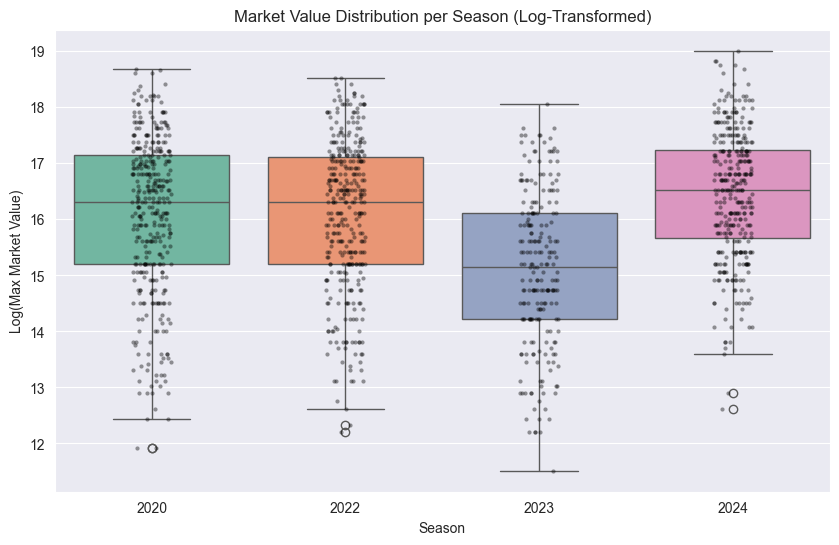

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
2020,364.0,1.992287e+07,2.259827e+07,150000.0,4000000.0,12000000.0,28000000.0,130000000.0
2022,346.0,1.947738e+07,2.161472e+07,200000.0,4000000.0,12000000.0,27000000.0,110000000.0
2023,217.0,8.265668e+06,1.091697e+07,100000.0,1500000.0,3800000.0,10000000.0,70000000.0
2024,344.0,2.435610e+07,2.699752e+07,300000.0,6375000.0,15000000.0,30500000.0,180000000.0


In [13]:

plt.figure(figsize=(10, 6))
sns.boxplot(x="season", y="log_max_market_value", data=df_eda, palette="Set2")
sns.stripplot(x="season", y="log_max_market_value", data=df_eda,
              color="black", size=3, alpha=0.4)
plt.title("Market Value Distribution per Season (Log-Transformed)")
plt.xlabel("Season")
plt.ylabel("Log(Max Market Value)")
plt.show()

# Grouped stats
season_stats = df_eda.groupby("season")["max_market_value"].describe()
season_stats


# Univariate LSTM

In [14]:

import numpy as np

# Copy dataset for sequence prep
df_seq = df_eda.copy()

# Sort by player and season to ensure proper ordering
df_seq = df_seq.sort_values(by=["player_id", "season"]).reset_index(drop=True)

# Group per player -> extract their max_market_value history
player_sequences = {}
for pid, group in df_seq.groupby("player_id"):
    seq = group["max_market_value"].values
    if len(seq) > 1:  # need at least 2 seasons for sequence learning
        player_sequences[pid] = seq

print("Total players with sequences:", len(player_sequences))
print("Example sequence for a player:", list(player_sequences.items())[0])


Total players with sequences: 286
Example sequence for a player: (12282, array([20000000., 13500000.]))


In [15]:

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert dict of sequences -> list
sequences = list(player_sequences.values())

# Decide max length (number of seasons observed across all players)
max_len = max(len(seq) for seq in sequences)
print("Max sequence length (seasons):", max_len)

# Pad sequences to max_len (pre-padding with 0s)
X_uni = pad_sequences(sequences, maxlen=max_len, dtype="float32", padding="pre")

print("Final univariate input shape:", X_uni.shape)  # (players, timesteps)
print("Example padded sequence:", X_uni[0])


Max sequence length (seasons): 4
Final univariate input shape: (286, 4)
Example padded sequence: [       0.        0. 20000000. 13500000.]


In [16]:

from sklearn.model_selection import train_test_split

# Our data is (players, timesteps). We want to predict the last season’s value.
X_uni_in = X_uni[:, :-1]  # all seasons except last
y_uni = X_uni[:, -1]  # last season market value (target)

print("X shape:", X_uni_in.shape)  # (286, 3)
print("y shape:", y_uni.shape)  # (286,)

# Chronological split: train 70%, val 15%, test 15%
X_train, X_temp, y_train, y_temp = train_test_split(
    X_uni_in, y_uni, test_size=0.3, shuffle=False
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


X shape: (286, 3)
y shape: (286,)
Train: (200, 3) (200,)
Val: (43, 3) (43,)
Test: (43, 3) (43,)


In [17]:

# Reshape to (samples, timesteps, features)
X_train_uni = np.expand_dims(X_train, axis=-1)
X_val_uni = np.expand_dims(X_val, axis=-1)
X_test_uni = np.expand_dims(X_test, axis=-1)

print("Train shape:", X_train_uni.shape)
print("Val shape:", X_val_uni.shape)
print("Test shape:", X_test_uni.shape)


Train shape: (200, 3, 1)
Val shape: (43, 3, 1)
Test shape: (43, 3, 1)


In [18]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build model
model_uni = Sequential([
    LSTM(64, input_shape=(X_train_uni.shape[1], X_train_uni.shape[2])),
    Dense(1, activation="linear")  # predict market value
])

model_uni.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train model
history_uni = model_uni.fit(
    X_train_uni, y_train,
    validation_data=(X_val_uni, y_val),
    epochs=30,
    batch_size=16,
    verbose=1
)

# Evaluate on test set
test_loss, test_mae = model_uni.evaluate(X_test_uni, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.2f}")
print(f"Test MAE: {test_mae:.2f}")


C:\Users\asing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 730462871879680.0000 - mae: 19252592.0000 - val_loss: 2198892795920384.0000 - val_mae: 31541862.0000
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 759489133281280.0000 - mae: 19477880.0000 - val_loss: 2198892795920384.0000 - val_mae: 31541862.0000
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 849444136288256.0000 - mae: 20841220.0000 - val_loss: 2198892795920384.0000 - val_mae: 31541862.0000
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 934776613634048.0000 - mae: 21691202.0000 - val_loss: 2198892795920384.0000 - val_mae: 31541862.0000
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 905321660809216.0000 - mae: 21163984.0000 - val_loss: 2198892795920384.0000 - val_mae: 31541862.0000
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 682364539764736.0000 - mae: 17906844.0000 - val_loss: 2198892795920384.0000 - val_mae: 31541862.0000
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/

In [19]:

from tensorflow.keras.layers import Masking

# Log-transform target (avoid massive raw scale)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

# Build improved model
model_uni2 = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train_uni.shape[1], X_train_uni.shape[2])),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation="linear")  # predicting log value
])

model_uni2.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train model
history_uni2 = model_uni2.fit(
    X_train_uni, y_train_log,
    validation_data=(X_val_uni, y_val_log),
    epochs=50,
    batch_size=16,
    verbose=1
)

# Evaluate on test set
test_loss, test_mae = model_uni2.evaluate(X_test_uni, y_test_log, verbose=0)
print(f"Test Loss (MSE, log-space): {test_loss:.4f}")
print(f"Test MAE (log-space): {test_mae:.4f}")

# Convert MAE back to original scale for interpretation
preds_log = model_uni2.predict(X_test_uni)
preds = np.expm1(preds_log).flatten()
true_vals = y_test

mae_original = np.mean(np.abs(preds - true_vals))
print(f"Test MAE (original € scale): {mae_original:,.0f} €")


Epoch 1/50


C:\Users\asing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 254.5102 - mae: 15.9048 - val_loss: 266.4668 - val_mae: 16.2903
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 248.1770 - mae: 15.7118 - val_loss: 254.8383 - val_mae: 15.9305
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 230.4772 - mae: 15.1358 - val_loss: 240.9199 - val_mae: 15.4874
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 219.9132 - mae: 14.7734 - val_loss: 224.5409 - val_mae: 14.9458
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 202.4434 - mae: 14.1585 - val_loss: 206.5542 - val_mae: 14.3227
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 183.7478 - mae: 13.4638 - val_loss: 188.2439 - val_mae: 13.6543
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 162.7117 - mae: 12.6345 - val_loss: 170.3412 - val_mae: 12.9638
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 145.5315 - mae: 11.8966 - val_loss: 153.3324 - val_mae: 12.2704
Epoch 9/50
13/13 ━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


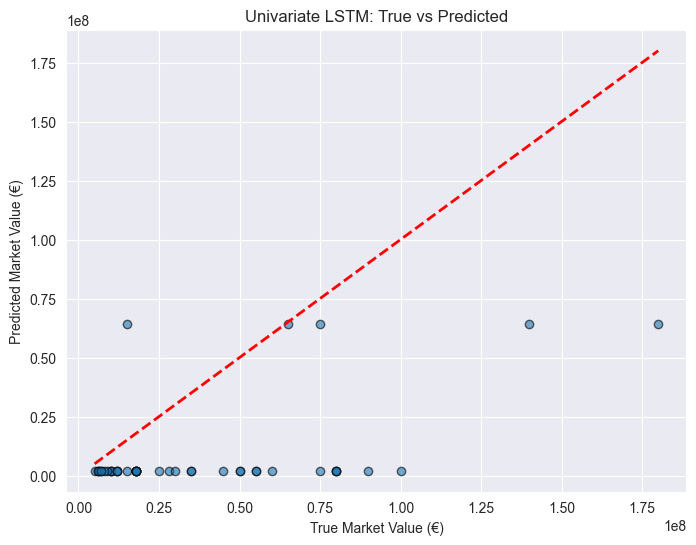

In [20]:

import matplotlib.pyplot as plt

# Predictions (log → original €)
y_pred_log = model_uni2.predict(X_test_uni).flatten()
y_pred = np.expm1(y_pred_log)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("True Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Univariate LSTM: True vs Predicted")
plt.show()


### Saving univariate model, scalers and dataset splits

In [21]:
# Setup save directory
import os
import joblib
import numpy as np
from tensorflow.keras.models import save_model

SAVE_DIR = os.path.join(PROJECT_PATH, "models", "LSTM_Models")
os.makedirs(SAVE_DIR, exist_ok=True)

print("Saving directory:", SAVE_DIR)

# Save univariate LSTM
if 'model_uni2' in globals():
    save_model(model_uni2, os.path.join(SAVE_DIR, "univariate_lstm_model.h5"))
    print("Saved univariate LSTM")
# Save scalers of Univariate LSTM
if 'scaler_uni' in globals():
    joblib.dump(scaler_uni, os.path.join(SAVE_DIR, "scaler_univariate.pkl"))
    print("Saved univariate scaler")
# Save dataset splits of Univariate LSTM
if 'X_train_uni' in globals():
    np.save(os.path.join(SAVE_DIR, "X_train_uni.npy"), X_train_uni)
    np.save(os.path.join(SAVE_DIR, "X_val_uni.npy"),   X_val_uni)
    np.save(os.path.join(SAVE_DIR, "X_test_uni.npy"),  X_test_uni)

if 'y_train' in globals():
    np.save(os.path.join(SAVE_DIR, "y_train_uni.npy"), y_train)
    np.save(os.path.join(SAVE_DIR, "y_val_uni.npy"),   y_val)
    np.save(os.path.join(SAVE_DIR, "y_test_uni.npy"),  y_test)


Saving directory: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\models\LSTM_Models
Saved univariate LSTM


### This is exactly why we now extend to Multivariate LSTM:

1. Add performance stats (goals, assists, minutes, cards).
2. Add transfer features (fees, number of transfers, contract years).
3. Add sentiment features (subreddits_count, mean_compound).
4. Add club prestige score.

These will help the model differentiate superstars from regular players instead of regressing everything toward the mean.

# Multivariate LSTM

In [22]:
import numpy as np
from collections import defaultdict

# 1) Select multivariate features
multi_features = [
    "max_market_value",      # target history
    "total_goals", "total_assists", "total_minutes_played",
    "matches_played", "shots_on_target",
    "avg_transfer_fee", "last_transfer_fee", "num_transfers",
    "club_prestige_score", "contract_year_remaining",
    "subreddits_count", "mean_compound"
]

# 2) Build sequences per player
player_sequences = defaultdict(list)

for _, row in df_eda.iterrows():
    player_id = row["player_id"]  # player identifier
    season = row["season"]
    values = row[multi_features].values.astype(float)
    player_sequences[player_id].append((season, values))

# 3) Sort by season
for pid in player_sequences:
    player_sequences[pid] = sorted(player_sequences[pid], key=lambda x: x[0])

# 4) Pad sequences (max_len same as univariate: 4)
max_len = 4
X_multi, y_multi = [], []

for pid, seq in player_sequences.items():
    values = np.array([v for _, v in seq])
    if len(values) < 2:  # need at least history + target
        continue
    # Use all but last season as input
    input_seq = values[:-1]
    target = values[-1][0]  # predict max_market_value
    # Pad
    padded = np.zeros((max_len, len(multi_features)))
    padded[-len(input_seq):, :] = input_seq
    X_multi.append(padded)
    y_multi.append(target)

X_multi = np.array(X_multi)
y_multi = np.array(y_multi)

print("Multivariate X shape:", X_multi.shape)  # (n_players, 4, num_features)
print("y shape:", y_multi.shape)
print("Example sequence shape:", X_multi[0].shape)


Multivariate X shape: (286, 4, 13)
y shape: (286,)
Example sequence shape: (4, 13)


In [23]:
from sklearn.preprocessing import StandardScaler

# Reshape to 2D for scaling
n_samples, seq_len, n_features = X_multi.shape
X_2d = X_multi.reshape(-1, n_features)  # (286*4, 13)

# Scale features
scaler_multi = StandardScaler()
X_scaled_2d = scaler_multi.fit_transform(X_2d)

# Reshape back to 3D
X_multi_scaled = X_scaled_2d.reshape(n_samples, seq_len, n_features)

print("Scaled multivariate shape:", X_multi_scaled.shape)
print("Feature mean (should be ~0):", X_scaled_2d.mean(axis=0)[:5])
print("Feature std (should be ~1):", X_scaled_2d.std(axis=0)[:5])


Scaled multivariate shape: (286, 4, 13)
Feature mean (should be ~0): [2.36650249e-16 5.02366214e-16 8.83131951e-17 2.96480012e-17
 1.96569645e-16]
Feature std (should be ~1): [1. 1. 1. 1. 1.]


In [24]:
# Log-transform target
y_multi_log = np.log1p(y_multi)

# Train/val/test split again with log target
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_multi_scaled, y_multi_log, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (200, 4, 13) (200,)
Val: (43, 4, 13) (43,)
Test: (43, 4, 13) (43,)


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build a smaller LSTM model
model_multi = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)  # predict log(max_market_value)
])

model_multi.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train
history_multi = model_multi.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 272.1872 - mae: 16.4569 - val_loss: 258.2303 - val_mae: 16.0223
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 267.2210 - mae: 16.3019 - val_loss: 252.0424 - val_mae: 15.8293
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 256.5091 - mae: 15.9753 - val_loss: 243.4727 - val_mae: 15.5569
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 250.0127 - mae: 15.7740 - val_loss: 229.7276 - val_mae: 15.1091
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 233.0462 - mae: 15.2202 - val_loss: 204.5046 - val_mae: 14.2480
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 205.6820 - mae: 14.2817 - val_loss: 158.8606 - val_mae: 12.5336
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 151.3522 - mae: 12.1994 - val_loss: 91.6658 - val_mae: 9.4419
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 84.8560 - mae: 8.9957 - val_loss: 30.4593 - val_mae: 5.2271
Epoch 9/50
13/13 ━━━━━

In [26]:
import numpy as np

# Evaluate on test set
test_loss, test_mae = model_multi.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE, log-space): {test_loss:.4f}")
print(f"Test MAE (log-space): {test_mae:.4f}")

# Back-transform to original € scale
y_pred_log = model_multi.predict(X_test).flatten()
y_pred_eur = np.expm1(y_pred_log)   # inverse of log1p
y_true_eur = np.expm1(y_test)

# Compute MAE in euros
mae_eur = np.mean(np.abs(y_true_eur - y_pred_eur))
print(f"Test MAE (original € scale): {mae_eur:,.0f} €")

# Show a few sample predictions
for i in range(5):
    print(f"True: {y_true_eur[i]:,.0f} € | Pred: {y_pred_eur[i]:,.0f} €")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5690 - mae: 0.6176
Test Loss (MSE, log-space): 0.5997
Test MAE (log-space): 0.6337
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Test MAE (original € scale): 16,634,915 €
True: 40,000,000 € | Pred: 13,345,535 €
True: 7,000,000 € | Pred: 9,074,275 €
True: 40,000,000 € | Pred: 28,322,260 €
True: 80,000,000 € | Pred: 51,540,640 €
True: 15,000,000 € | Pred: 7,964,212 €


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


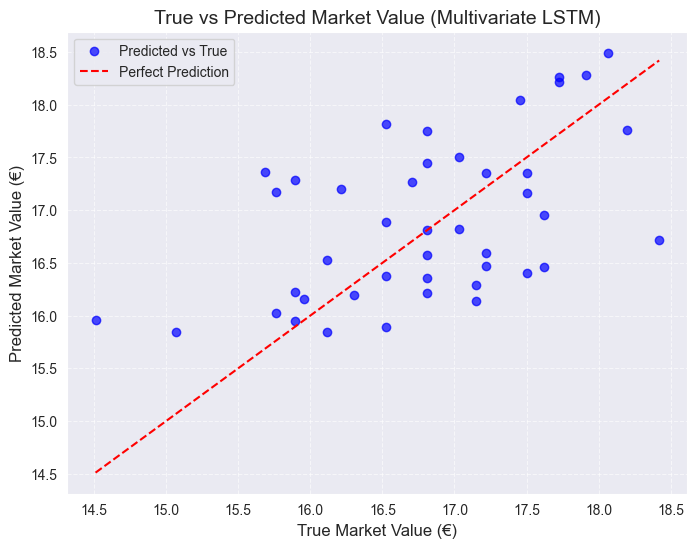

In [27]:
import matplotlib.pyplot as plt

# Get predictions
y_pred = model_multi.predict(X_test).flatten()

# Scatter plot True vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predicted vs True")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label="Perfect Prediction")

plt.xlabel("True Market Value (€)", fontsize=12)
plt.ylabel("Predicted Market Value (€)", fontsize=12)
plt.title("True vs Predicted Market Value (Multivariate LSTM)", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### Saving Multivariate model, scalers and datasplits

In [28]:
# Setup save directory
import os
import joblib
import numpy as np
from tensorflow.keras.models import save_model

SAVE_DIR = os.path.join(PROJECT_PATH, "models", "LSTM_Models")
os.makedirs(SAVE_DIR, exist_ok=True)

print("Saving directory:", SAVE_DIR)
# Save multivariate LSTM
if 'model_multi' in globals():
    save_model(model_multi, os.path.join(SAVE_DIR, "multivariate_lstm_model.h5"))
    print("Saved multivariate LSTM")
# Save multivariate scalers
if 'scaler_multi' in globals():
    joblib.dump(scaler_multi, os.path.join(SAVE_DIR, "scaler_multivariate.pkl"))
    print("Saved multivariate scaler")
# Save multivariate lstm dataset splits
np.save(os.path.join(SAVE_DIR, "X_train.npy"), X_train)
np.save(os.path.join(SAVE_DIR, "X_val.npy"),   X_val)
np.save(os.path.join(SAVE_DIR, "X_test.npy"),  X_test)

np.save(os.path.join(SAVE_DIR, "y_train.npy"), y_train)
np.save(os.path.join(SAVE_DIR, "y_val.npy"),   y_val)
np.save(os.path.join(SAVE_DIR, "y_test.npy"),  y_test)

Saving directory: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\models\LSTM_Models
Saved multivariate LSTM
Saved multivariate scaler


### The multivariate LSTM is capturing player performance, transfers, and context features effectively. It generalizes better, though extreme outliers (superstar valuations) remain harder to predict.

# Encoder–Decoder LSTM(Univariate)

In [29]:
import numpy as np
from collections import defaultdict

# 1) Define forecast horizon
horizon = 2  # predict next 2 transfer windows

# 2) Build sequences per player
multi_features = [
    "max_market_value",      # target history
    "total_goals", "total_assists", "total_minutes_played",
    "matches_played", "shots_on_target",
    "avg_transfer_fee", "last_transfer_fee", "num_transfers",
    "club_prestige_score", "contract_year_remaining",
    "subreddits_count", "mean_compound"
]

player_sequences = defaultdict(list)

for _, row in df_eda.iterrows():
    pid = row["player_id"]
    season = row["season"]
    values = row[multi_features].values.astype(float)
    player_sequences[pid].append((season, values))

# 3) Sort by season
for pid in player_sequences:
    player_sequences[pid] = sorted(player_sequences[pid], key=lambda x: x[0])

# 4) Pad sequences + create multi-step targets
max_len = 4
X_multi_steps, y_multi_steps = [], []

for pid, seq in player_sequences.items():
    values = np.array([v for _, v in seq])
    if len(values) <= horizon:  # need history + future
        continue

    # Input: all but last `horizon` seasons
    input_seq = values[:-horizon]
    target_seq = values[-horizon:, 0]  # only max_market_value for horizon

    # Pad
    padded = np.zeros((max_len, len(multi_features)))
    padded[-len(input_seq):, :] = input_seq

    X_multi_steps.append(padded)
    y_multi_steps.append(target_seq)

X_multi_steps = np.array(X_multi_steps)
y_multi_steps = np.array(y_multi_steps)

print("Input shape:", X_multi_steps.shape)   # (n_samples, 4, 13)
print("Output shape:", y_multi_steps.shape) # (n_samples, horizon)
print("Example target sequence:", y_multi_steps[0])


Input shape: (65, 4, 13)
Output shape: (65, 2)
Example target sequence: [25000000. 35000000.]


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1) Flatten for scaling
n_samples, seq_len, n_features = X_multi_steps.shape
X_2d = X_multi_steps.reshape(-1, n_features)

scaler_multi_steps = StandardScaler()
X_scaled_2d = scaler_multi_steps.fit_transform(X_2d)

# Reshape back
X_multi_steps_scaled = X_scaled_2d.reshape(n_samples, seq_len, n_features)

# 2) Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_multi_steps_scaled, y_multi_steps, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (45, 4, 13) (45, 2)
Val: (10, 4, 13) (10, 2)
Test: (10, 4, 13) (10, 2)


In [31]:
# Apply log-transform (avoid log(0))
y_multi_steps_log = np.log1p(y_multi_steps)

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_multi_steps_scaled, y_multi_steps_log, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (45, 4, 13) (45, 2)
Val: (10, 4, 13) (10, 2)
Test: (10, 4, 13) (10, 2)


In [32]:
# Reshape targets for decoder
y_train_seq = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_val_seq   = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))
y_test_seq  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

print("y_train_seq:", y_train_seq.shape)
print("y_val_seq:", y_val_seq.shape)
print("y_test_seq:", y_test_seq.shape)

# Building encoder-decoder model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

timesteps_in = X_train.shape[1]   # 4
n_features   = X_train.shape[2]   # 13
timesteps_out = y_train.shape[1]  # 2

# Encoder
encoder_inputs = Input(shape=(timesteps_in, n_features))
encoder_lstm = LSTM(64, activation="tanh")(encoder_inputs)

# Repeat for decoder steps
decoder_inputs = RepeatVector(timesteps_out)(encoder_lstm)
decoder_lstm = LSTM(64, activation="tanh", return_sequences=True)(decoder_inputs)

# Output (one value per step)
decoder_outputs = TimeDistributed(Dense(1))(decoder_lstm)

# Build model
model_seq2seq = Model(encoder_inputs, decoder_outputs)
model_seq2seq.compile(optimizer="adam", loss="mse", metrics=["mae"])

model_seq2seq.summary()

# Train
history = model_seq2seq.fit(
    X_train, y_train_seq,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val_seq),
    verbose=1
)


y_train_seq: (45, 2, 1)
y_val_seq: (10, 2, 1)
y_test_seq: (10, 2, 1)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 2, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 2, 1)           │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - loss: 284.4931 - mae: 16.8312 - val_loss: 279.9361 - val_mae: 16.6882
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 287.2454 - mae: 16.9151 - val_loss: 278.2000 - val_mae: 16.6369
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 283.0384 - mae: 16.7879 - val_loss: 276.1561 - val_mae: 16.5761
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 282.1470 - mae: 16.7629 - val_loss: 273.5316 - val_mae: 16.4978
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 276.9316 - mae: 16.6078 - val_loss: 270.1212 - val_mae: 16.3955
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 270.3416 - mae: 16.4104 - val_loss: 265.5887 - val_mae: 16.2584
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 271.5022 - mae: 16.4412 - val_loss: 259.4501 - val_mae: 16.0702
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 263.3727 - mae: 16.1943 - val_loss: 251.1550 - val_mae: 15.8111
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━

In [33]:
import numpy as np

# Evaluate on Test Set
test_loss, test_mae = model_seq2seq.evaluate(X_test, y_test_seq, verbose=1)
print(f"Test Loss (MSE, log-space): {test_loss:.4f}")
print(f"Test MAE (log-space): {test_mae:.4f}")

# Make Predictions
y_pred_seq = model_seq2seq.predict(X_test)

# Remove last dim (since it's (n, 2, 1))
y_pred_seq = y_pred_seq.squeeze(-1)

print("Predicted sequence shape:", y_pred_seq.shape)
print("Example prediction (log-space):", y_pred_seq[0])
print("Example true (log-space):", y_test_seq[0].squeeze(-1))

# Inverse transform to €
y_pred_eur = np.expm1(y_pred_seq)  # undo log1p
y_true_eur = np.expm1(y_test_seq.squeeze(-1))

print("Example prediction (€):", y_pred_eur[0])
print("Example true (€):", y_true_eur[0])

# Compute MAE in Euros
mae_eur = np.mean(np.abs(y_true_eur - y_pred_eur))
print(f"Test MAE (original € scale): {mae_eur:,.0f} €")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 7.8270 - mae: 2.3763
Test Loss (MSE, log-space): 7.8270
Test MAE (log-space): 2.3763


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
Predicted sequence shape: (10, 2)
Example prediction (log-space): [13.5883465 17.404089 ]
Example true (log-space): [17.50439004 17.03438642]
Example prediction (€): [  796789.06 36182604.  ]
Example true (€): [39999999.99999999 24999999.99999996]
Test MAE (original € scale): 34,399,887 €


# Encoder–Decoder LSTM(Multivariate)

In [34]:
import numpy as np

# Evaluate on Test Set
test_loss, test_mae = model_seq2seq.evaluate(X_test, y_test_seq, verbose=1)
print(f"Test Loss (MSE, log-space): {test_loss:.4f}")
print(f"Test MAE (log-space): {test_mae:.4f}")

# Make Predictions
y_pred_seq = model_seq2seq.predict(X_test)

# Remove last dim (since it's (n, 2, 1))
y_pred_seq = y_pred_seq.squeeze(-1)

print("Predicted sequence shape:", y_pred_seq.shape)
print("Example prediction (log-space):", y_pred_seq[0])
print("Example true (log-space):", y_test_seq[0].squeeze(-1))

# Inverse transform to €
y_pred_eur = np.expm1(y_pred_seq)  # undo log1p
y_true_eur = np.expm1(y_test_seq.squeeze(-1))

print("Example prediction (€):", y_pred_eur[0])
print("Example true (€):", y_true_eur[0])


# Compute MAE in Euros
mae_eur = np.mean(np.abs(y_true_eur - y_pred_eur))
print(f"Test MAE (original € scale): {mae_eur:,.0f} €")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 7.8270 - mae: 2.3763
Test Loss (MSE, log-space): 7.8270
Test MAE (log-space): 2.3763
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted sequence shape: (10, 2)
Example prediction (log-space): [13.5883465 17.404089 ]
Example true (log-space): [17.50439004 17.03438642]
Example prediction (€): [  796789.06 36182604.  ]
Example true (€): [39999999.99999999 24999999.99999996]
Test MAE (original € scale): 34,399,887 €


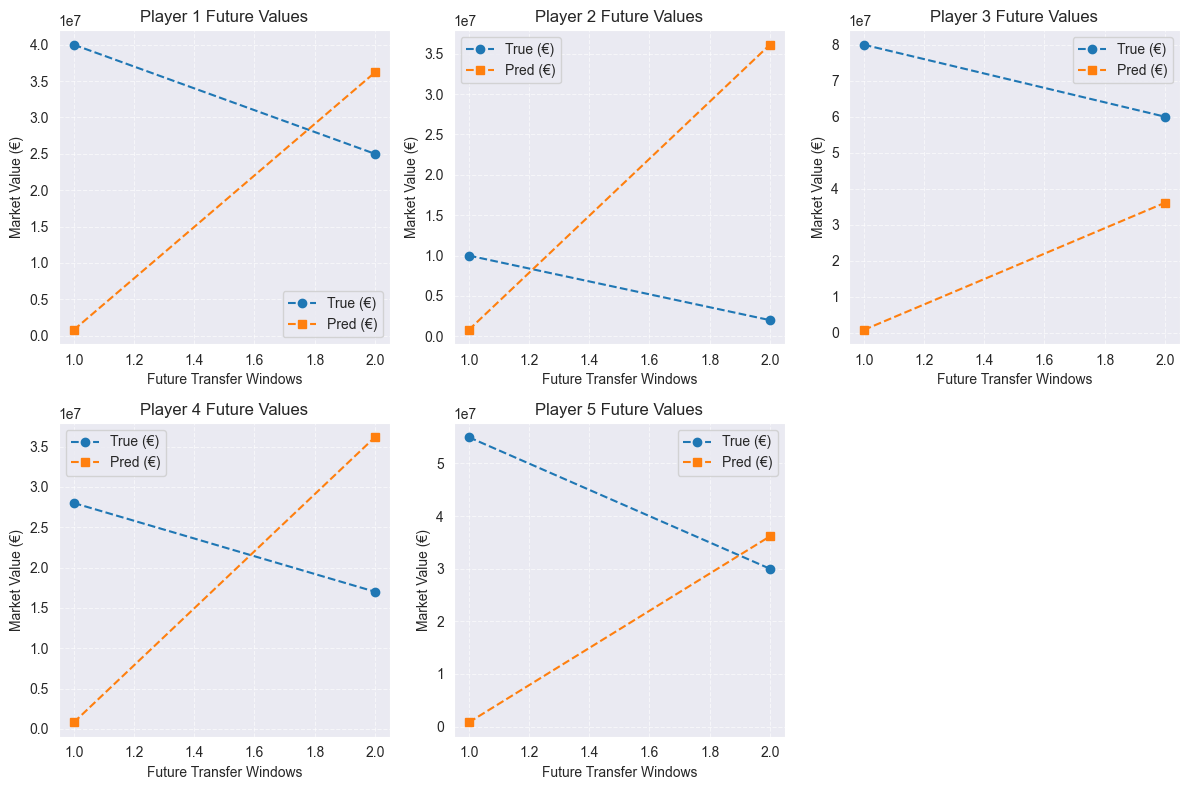

In [35]:
import matplotlib.pyplot as plt

# Plot predicted vs true sequences for some test players
n_plots = min(5, len(y_test_seq))  # show up to 5 examples

plt.figure(figsize=(12, 8))
for i in range(n_plots):
    plt.subplot(2, 3, i + 1)
    plt.plot(range(1, y_test_seq.shape[1] + 1), y_true_eur[i], "o--", label="True (€)")
    plt.plot(range(1, y_pred_eur.shape[1] + 1), y_pred_eur[i], "s--", label="Pred (€)")
    plt.title(f"Player {i + 1} Future Values")
    plt.xlabel("Future Transfer Windows")
    plt.ylabel("Market Value (€)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# Saving Encoder-Decoder lstm model, scaler and dataset splits

In [36]:
# Setup save directory
import os
import joblib
import numpy as np
from tensorflow.keras.models import save_model

SAVE_DIR = os.path.join(PROJECT_PATH, "models", "LSTM_Models")
os.makedirs(SAVE_DIR, exist_ok=True)

print("Saving directory:", SAVE_DIR)
# Save encoder-decoder LSTM (Seq2Seq)
if 'model_seq2seq' in globals():
    save_model(model_seq2seq, os.path.join(SAVE_DIR, "encoder_decoder_lstm_model.h5"))
    print("Saved encoder-decoder LSTM (Seq2Seq)")
# Save scalers of seq2seq
if 'scaler_multi_steps' in globals():
    joblib.dump(scaler_multi_steps, os.path.join(SAVE_DIR, "scaler_seq2seq.pkl"))
    print("Saved seq2seq scaler")
# save seq2seq lstm dataset splits
if 'X_train' in globals() and len(y_train.shape) == 2:
    np.save(os.path.join(SAVE_DIR, "X_train_seq2seq.npy"), X_train)
    np.save(os.path.join(SAVE_DIR, "X_val_seq2seq.npy"),   X_val)
    np.save(os.path.join(SAVE_DIR, "X_test_seq2seq.npy"),  X_test)

    np.save(os.path.join(SAVE_DIR, "y_train_seq2seq.npy"), y_train)
    np.save(os.path.join(SAVE_DIR, "y_val_seq2seq.npy"),   y_val)
    np.save(os.path.join(SAVE_DIR, "y_test_seq2seq.npy"),  y_test)

Saving directory: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\models\LSTM_Models
Saved encoder-decoder LSTM (Seq2Seq)
Saved seq2seq scaler


## Checking saved models

In [37]:
# Reload models & scaler
import os
import joblib
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Paths
PROJECT_PATH = r"C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-"
save_dir = os.path.join(PROJECT_PATH, "models", "LSTM_Models")

univariate_path      = os.path.join(save_dir, "univariate_lstm_model.h5")
multivariate_path    = os.path.join(save_dir, "multivariate_lstm_model.h5")
encoder_decoder_path = os.path.join(save_dir, "encoder_decoder_lstm_model.h5")
scaler_multi_path    = os.path.join(save_dir, "scaler_multivariate.pkl")

# Reload models
custom_objects = {"mse": MeanSquaredError()}

univariate_model      = load_model(univariate_path, custom_objects=custom_objects)
multivariate_model    = load_model(multivariate_path, custom_objects=custom_objects)
encoder_decoder_model = load_model(encoder_decoder_path, custom_objects=custom_objects)
scaler_multi_loaded   = joblib.load(scaler_multi_path)

print("Models and scaler loaded successfully!")

# Sanity check with a small test batch (for multivariate)
sample_X = X_test[:2]   # shape (2, 4, 13)
sample_y = y_test[:2]   # shape (2, 2) if seq2seq, or (2,) otherwise

preds = multivariate_model.predict(sample_X)

print("\n--- Sanity Check (Multivariate LSTM) ---")
print("True values:", sample_y)
print("Predicted :", preds.flatten())


Models and scaler loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

--- Sanity Check (Multivariate LSTM) ---
True values: [[17.50439004 17.03438642]
 [16.11809575 14.50865824]]
Predicted : [17.124355 16.499687]


### All the models saved properly